In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("clean_data.csv")
df = df[~df['food_wheel_group'].isin(['Other'])].copy()

In [3]:
nutrient_cols = [
    'FAT (g)', 'PROT (g)', 'Calories (kcal)',
    'VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)',
    'VITE (mg)', 'VITC (mg)', 'VITA (µg)',
    'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Phosphorus (mg)',
    'Potassium (mg)', 'Sodium (mg)', 'Zinc (mg)'
]

df_clean = df.dropna(subset=nutrient_cols).copy()

In [4]:
df_clean['Protein_per_kcal'] = df_clean['PROT (g)'] / (df_clean['Calories (kcal)'] + 1)
df_clean['Fat_to_Protein'] = df_clean['FAT (g)'] / (df_clean['PROT (g)'] + 1)
df_clean['Cal_to_Protein'] = df_clean['Calories (kcal)'] / (df_clean['PROT (g)'] + 1)
df_clean['Sodium_to_Potassium'] = df_clean['Sodium (mg)'] / (df_clean['Potassium (mg)'] + 1)

micro_cols = ['VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)', 
              'VITE (mg)', 'VITC (mg)', 'VITA (µg)', 'Calcium (mg)', 'Iron (mg)', 
              'Magnesium (mg)', 'Phosphorus (mg)', 'Potassium (mg)', 'Zinc (mg)']
df_clean['Micronutrient_Density'] = df_clean[micro_cols].sum(axis=1) / (df_clean['Calories (kcal)'] + 1)

features = nutrient_cols + [
    'Protein_per_kcal', 'Fat_to_Protein', 'Cal_to_Protein',
    'Sodium_to_Potassium', 'Micronutrient_Density'
]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

In [6]:
sil_scores = {}
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

optimal_k = max(sil_scores, key=sil_scores.get)
print(f"Optimal number of clusters (diet types): {optimal_k} (Silhouette = {sil_scores[optimal_k]:.3f})")

Optimal number of clusters (diet types): 4 (Silhouette = 0.319)


In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['diet_cluster'] = kmeans.fit_predict(X_scaled)

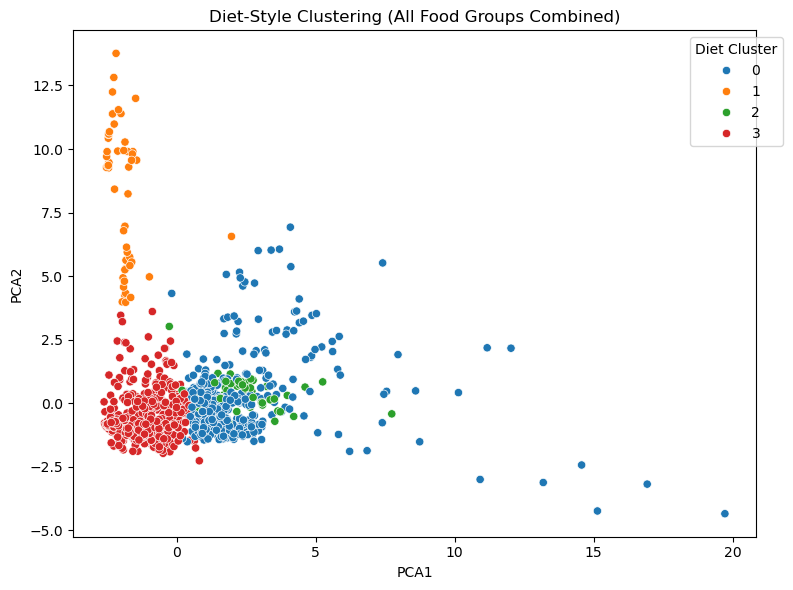

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_clean['PCA1'] = pca_result[:, 0]
df_clean['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='diet_cluster', palette='tab10')
plt.title("Diet-Style Clustering (All Food Groups Combined)")
plt.legend(title="Diet Cluster", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [9]:
print("\n=== Diet Cluster Nutrient Profiles ===")
cluster_profiles = df_clean.groupby('diet_cluster')[features].mean().round(2)
print(cluster_profiles)

print("\n=== Food Group Composition per Diet Cluster ===")
composition = df_clean.groupby(['diet_cluster', 'food_wheel_group']).size()
display(composition)

print("\n=== Food Subgroup Composition per Diet Cluster ===")
subcomposition = df_clean.groupby(['diet_cluster', 'food_wheel_subgroup']).size()
display(subcomposition)


=== Diet Cluster Nutrient Profiles ===
              FAT (g)  PROT (g)  Calories (kcal)  VITB1 (mg)  RIBF (mg)  \
diet_cluster                                                              
0               14.10     18.65           268.92        0.31       0.29   
1               79.04      0.19           713.49        0.04       0.03   
2               21.60     22.18           311.15        0.05       0.33   
3                3.81      3.67           122.14        0.06       0.08   

              VITB6 (mg)  VITB12 (µg)  VITD (µg)  VITE (mg)  VITC (mg)  ...  \
diet_cluster                                                            ...   
0                   0.36         3.09       1.27       2.51       2.11  ...   
1                   0.03         0.08       3.74      18.70       0.00  ...   
2                   0.08         1.73       0.24       0.88       0.75  ...   
3                   0.08         0.12       0.10       0.81       9.48  ...   

              Magnesium (mg)  Phos

diet_cluster  food_wheel_group                         
0             Bread, grain/cereal products and potatoes     87
              Dairy, nuts, fish, legumes, meat and eggs    314
              Drinks                                         2
              Spreading and cooking fats                    18
              Vegetables and fruit                           6
1             Spreading and cooking fats                    51
2             Bread, grain/cereal products and potatoes      2
              Dairy, nuts, fish, legumes, meat and eggs     57
              Drinks                                         1
              Vegetables and fruit                           1
3             Bread, grain/cereal products and potatoes    177
              Dairy, nuts, fish, legumes, meat and eggs    211
              Drinks                                        92
              Spreading and cooking fats                    21
              Vegetables and fruit                         295


=== Food Subgroup Composition per Diet Cluster ===


diet_cluster  food_wheel_subgroup                      
0             Bread, grain/cereal products and potatoes     87
              Dairy                                          2
              Drinks                                         2
              Fish, legumes, meat and eggs                 279
              Fruit                                          1
              Nuts                                          33
              Spreading and cooking fats                    18
              Vegetables                                     5
1             Spreading and cooking fats                    51
2             Bread, grain/cereal products and potatoes      2
              Dairy                                         52
              Drinks                                         1
              Fish, legumes, meat and eggs                   5
              Vegetables                                     1
3             Bread, grain/cereal products and potatoes    177

In [10]:
cluster_profiles.to_csv("diet_cluster_profiles.csv")

In [11]:
def classify_diet_label(row):
    labels = []

    # --- From cluster ---
    cluster = row.get('diet_cluster')

    if cluster == 0:
        labels.append('Continental Diet')
    elif cluster == 3:
        labels.append('Plant-Focused Flexitarian Diet')

    # --- From food group (vegetarian tagging) ---
    group = row.get('food_wheel_group')

    vegetarian_groups = [
        'Bread, grain/cereal products and potatoes',
        'Vegetables and fruit',
        'Dairy, nuts, fish, legumes, meat and eggs',
        'Spreading and cooking fats',
        'Drinks'
    ]

    group = row.get('food_wheel_group')
    if group in vegetarian_groups:
        labels.append('Vegetarian')

    # --- Final output ---
    if len(labels) == 0:
        return np.nan
    return labels

In [12]:
df_clean['diet_label'] = df_clean.apply(classify_diet_label, axis=1)

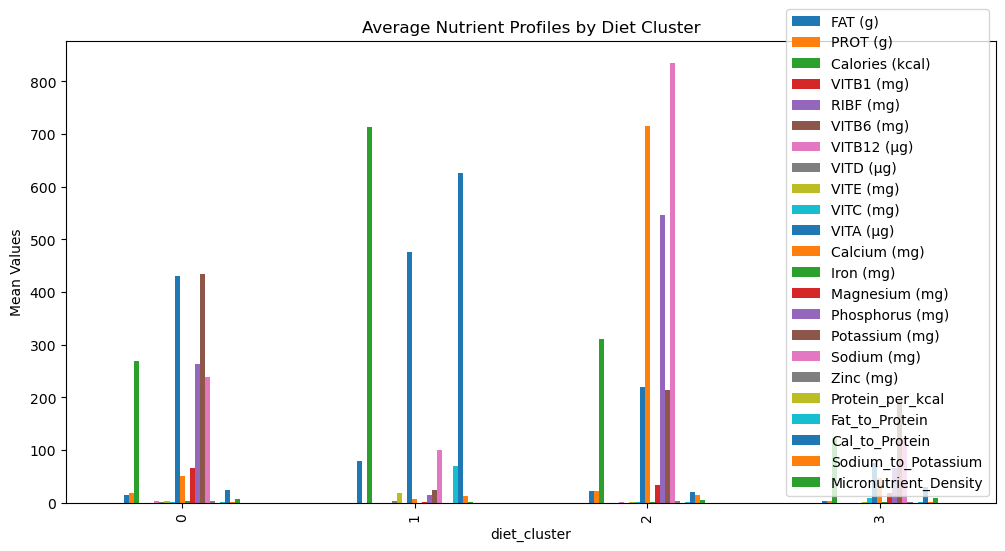

In [13]:
cluster_profiles.plot(kind='bar', figsize=(12, 6))
plt.title("Average Nutrient Profiles by Diet Cluster")
plt.ylabel("Mean Values")
plt.show()

In [14]:
df_clean

,NEVO-code,food_name,FAT (g),PROT (g),Calories (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),VITB12 (µg),VITD (µg),...,food_wheel_subgroup,Protein_per_kcal,Fat_to_Protein,Cal_to_Protein,Sodium_to_Potassium,Micronutrient_Density,diet_cluster,PCA1,PCA2,diet_label
0,1,Potatoes raw,0.0,2.0,88.0,0.12,0.04,0.300,0.00,0.0,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.229551,3,-1.080330,-0.855779,"[Plant-Focused Flexitarian Diet, Vegetarian]"
1,2,Potatoes new raw,0.0,2.0,88.0,0.12,0.04,0.300,0.00,0.0,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.250112,3,-1.193904,-0.927824,"[Plant-Focused Flexitarian Diet, Vegetarian]"
2,3,Potatoes old raw,0.0,2.0,88.0,0.12,0.04,0.220,0.00,0.0,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.070562,3,-1.138597,-0.820901,"[Plant-Focused Flexitarian Diet, Vegetarian]"
3,4,Pasta white raw,1.5,12.3,356.0,0.10,0.06,0.080,0.00,0.0,...,"Bread, grain/cereal products and potatoes",0.034454,0.112782,26.766917,0.019802,0.831204,3,-0.261089,-0.135707,"[Plant-Focused Flexitarian Diet, Vegetarian]"
4,5,Rice white raw,1.0,7.0,352.0,0.04,0.03,0.120,0.00,0.0,...,"Bread, grain/cereal products and potatoes",0.019830,0.125000,44.000000,0.019802,0.638782,3,-1.081895,-0.065951,"[Plant-Focused Flexitarian Diet, Vegetarian]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,5571,Drink soya chocolate w sugar fortified w calci...,1.7,3.0,60.0,0.02,0.20,0.047,0.00,0.7,...,"Fish, legumes, meat and eggs",0.049180,0.425000,15.000000,0.309392,6.657164,3,-1.117849,-0.824359,"[Plant-Focused Flexitarian Diet, Vegetarian]"
2003,5572,Bacon vegetarian unprepared,10.5,15.0,185.0,0.04,0.17,0.041,0.00,0.0,...,"Fish, legumes, meat and eggs",0.080645,0.656250,11.562500,2.510689,3.865973,0,0.925230,-0.326722,"[Continental Diet, Vegetarian]"
2004,5573,Tempeh unprepared,4.7,17.6,128.0,0.03,0.18,0.091,0.02,0.0,...,"Fish, legumes, meat and eggs",0.136434,0.252688,6.881720,0.125402,5.058302,0,0.665009,-0.941200,"[Continental Diet, Vegetarian]"
2005,5574,Bakery mix for doughnuts Dutch style,1.0,11.0,367.0,0.09,0.09,0.134,0.00,0.0,...,"Bread, grain/cereal products and potatoes",0.029891,0.083333,30.583333,4.047619,0.875826,3,-0.412096,0.034875,"[Plant-Focused Flexitarian Diet, Vegetarian]"


### Add tagging for "high in {nutrient}" and "low in {nutrient}" for the top and bottom 10%

In [15]:
# 90th percentile thresholds for "High in ..."
high_thresholds = {nutrient: df_clean[nutrient].quantile(0.9) for nutrient in nutrient_cols}

print("=== 90th Percentile Thresholds for 'High in ...' ===")
for nutrient, value in high_thresholds.items():
    print(f"{nutrient}: {value:.2f}")

# 10th percentile thresholds for "Low in ..."
low_thresholds = {nutrient: df_clean[nutrient].quantile(0.1) for nutrient in nutrient_cols}

print("\n=== 10th Percentile Thresholds for 'Low in ...' ===")
for nutrient, value in low_thresholds.items():
    print(f"{nutrient}: {value:.2f}")

def tag_all(row):
    tags = []

    # High tags
    for nutrient, threshold in high_thresholds.items():
        if row.get(nutrient, 0) >= threshold:
            tags.append(f"High in {nutrient}")

    # Low tags
    for nutrient, threshold in low_thresholds.items():
        if row.get(nutrient, 0) <= threshold:
            tags.append(f"Low in {nutrient}")

    return tags if tags else np.nan

=== 90th Percentile Thresholds for 'High in ...' ===
FAT (g): 30.76
PROT (g): 23.00
Calories (kcal): 402.00
VITB1 (mg): 0.37
RIBF (mg): 0.28
VITB6 (mg): 0.40
VITB12 (µg): 2.06
VITD (µg): 1.10
VITE (mg): 4.10
VITC (mg): 17.00
VITA (µg): 304.20
Calcium (mg): 134.00
Iron (mg): 2.80
Magnesium (mg): 71.60
Phosphorus (mg): 324.00
Potassium (mg): 497.00
Sodium (mg): 586.00
Zinc (mg): 3.56

=== 10th Percentile Thresholds for 'Low in ...' ===
FAT (g): 0.00
PROT (g): 0.30
Calories (kcal): 25.00
VITB1 (mg): 0.00
RIBF (mg): 0.01
VITB6 (mg): 0.01
VITB12 (µg): 0.00
VITD (µg): 0.00
VITE (mg): 0.00
VITC (mg): 0.00
VITA (µg): 0.00
Calcium (mg): 5.00
Iron (mg): 0.00
Magnesium (mg): 3.00
Phosphorus (mg): 12.00
Potassium (mg): 42.00
Sodium (mg): 2.00
Zinc (mg): 0.05


In [16]:
df_clean_demo = df_clean[[
    'NEVO-code', 'food_name', 'FAT (g)', 'PROT (g)',
    'Calories (kcal)', 'VITB12 (µg)', 'VITD (µg)', 'VITC (mg)', 
    'Iron (mg)', 'food_wheel_group', 'food_wheel_subgroup', 
    'diet_label'
]]

In [17]:
df_clean['tag'] = df_clean.apply(tag_all, axis=1)

In [18]:
df_clean_demo['tag'] = df_clean.apply(tag_all, axis=1)

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_37367/1819938977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_demo['tag'] = df_clean.apply(tag_all, axis=1)


In [19]:
df_clean.columns

Index(['NEVO-code', 'food_name', 'FAT (g)', 'PROT (g)', 'Calories (kcal)',
       'VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)',
       'VITE (mg)', 'VITC (mg)', 'VITA (µg)', 'Calcium (mg)', 'Iron (mg)',
       'Magnesium (mg)', 'Phosphorus (mg)', 'Potassium (mg)', 'Sodium (mg)',
       'Zinc (mg)', 'food_wheel_group', 'food_wheel_subgroup',
       'Protein_per_kcal', 'Fat_to_Protein', 'Cal_to_Protein',
       'Sodium_to_Potassium', 'Micronutrient_Density', 'diet_cluster', 'PCA1',
       'PCA2', 'diet_label', 'tag'],
      dtype='object')

In [20]:
df_clean.to_csv("final_dataset.csv", index=False)

In [21]:
df_clean_demo.to_csv("final_dataset_demo.csv", index=False)

In [22]:
df_clean_demo = pd.read_csv("final_dataset_demo.csv")

In [23]:
df_clean_demo

,NEVO-code,food_name,FAT (g),PROT (g),Calories (kcal),VITB12 (µg),VITD (µg),VITC (mg),Iron (mg),food_wheel_group,food_wheel_subgroup,diet_label,tag
0,1,Potatoes raw,0.0,2.0,88.0,0.00,0.0,14.0,0.5,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['Low in FAT (g)', 'Low in VITB12 (µg)', 'Low ..."
1,2,Potatoes new raw,0.0,2.0,88.0,0.00,0.0,25.0,0.5,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['High in VITC (mg)', 'Low in FAT (g)', 'Low i..."
2,3,Potatoes old raw,0.0,2.0,88.0,0.00,0.0,5.0,0.5,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['Low in FAT (g)', 'Low in VITB12 (µg)', 'Low ..."
3,4,Pasta white raw,1.5,12.3,356.0,0.00,0.0,0.0,2.0,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['Low in VITB12 (µg)', 'Low in VITD (µg)', 'Lo..."
4,5,Rice white raw,1.0,7.0,352.0,0.00,0.0,0.0,0.4,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['Low in VITB12 (µg)', 'Low in VITD (µg)', 'Lo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,5571,Drink soya chocolate w sugar fortified w calci...,1.7,3.0,60.0,0.00,0.7,0.0,0.5,"Dairy, nuts, fish, legumes, meat and eggs","Fish, legumes, meat and eggs","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['Low in VITB12 (µg)', 'Low in VITC (mg)', 'Lo..."
1331,5572,Bacon vegetarian unprepared,10.5,15.0,185.0,0.00,0.0,0.0,3.9,"Dairy, nuts, fish, legumes, meat and eggs","Fish, legumes, meat and eggs","['Continental Diet', 'Vegetarian']","['High in Iron (mg)', 'High in Sodium (mg)', '..."
1332,5573,Tempeh unprepared,4.7,17.6,128.0,0.02,0.0,0.0,1.7,"Dairy, nuts, fish, legumes, meat and eggs","Fish, legumes, meat and eggs","['Continental Diet', 'Vegetarian']","['Low in VITD (µg)', 'Low in VITC (mg)', 'Low ..."
1333,5574,Bakery mix for doughnuts Dutch style,1.0,11.0,367.0,0.00,0.0,0.0,1.0,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Plant-Focused Flexitarian Diet', 'Vegetarian']","['High in Sodium (mg)', 'Low in VITB12 (µg)', ..."


In [24]:
# Filter for foods that include 'Vegetarian'
vegetarian_df = df_clean_demo[df_clean_demo['diet_label'].apply(lambda x: 'Vegetarian' in x)]

# List of nutrient columns
nutrients = ['FAT (g)', 'PROT (g)', 'Calories (kcal)', 
             'VITB12 (µg)', 'VITD (µg)', 'VITC (mg)', 'Iron (mg)']

# Compute averages
average_nutrients = vegetarian_df[nutrients].mean()

# Print average nutrient values
print("Average nutrient values for Vegetarian foods:\n")
for nutrient, value in average_nutrients.items():
    print(f"{nutrient}: {value:.2f}")

# Get value counts of food subgroups
subgroups_counts = vegetarian_df['food_wheel_subgroup'].value_counts()

print("\nFood subgroups included in the Vegetarian diet (with counts):")
for subgroup in sorted(subgroups_counts.index):
    print(f"{subgroup}: {subgroups_counts[subgroup]}")

Average nutrient values for Vegetarian foods:

FAT (g): 10.79
PROT (g): 9.18
Calories (kcal): 200.31
VITB12 (µg): 1.14
VITD (µg): 0.62
VITC (mg): 6.36
Iron (mg): 1.23

Food subgroups included in the Vegetarian diet (with counts):
Bread, grain/cereal products and potatoes: 266
Dairy: 178
Drinks: 95
Fish, legumes, meat and eggs: 370
Fruit: 98
Nuts: 34
Spreading and cooking fats: 90
Vegetables: 204
